# Experiment 4

This is a similar experiment as in Experiment 3, but with the British Periodicals data from the Stanford Literary Lab. 

In [2]:
import spacy
import pandas as pd
%matplotlib inline
from ast import literal_eval
import numpy as np
import re
import json
from nltk.corpus import names
from collections import Counter
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [16, 6]
plt.style.use('ggplot')

In [3]:
nlp = spacy.load('en')

In [4]:
with open('../middlemarch.txt') as f: 
    mm = f.read()

In [5]:
textALength = len(mm) 

In [6]:
# Get chapter locations
chapterMatches = re.finditer('PRELUDE|CHAPTER|FINALE', mm)
chapterLocations = [match.start() for match in chapterMatches]
chapterLocations.append(textALength) # Add one to account for last chunk. 
len(chapterLocations)

89

In [7]:
def getChapters(text): 
    chapters = []
    for i, loc in enumerate(chapterLocations): 
        if i != len(chapterLocations)-1: 
            chapter = mm[loc:chapterLocations[i+1]]
            chapters.append(chapter)
    return chapters

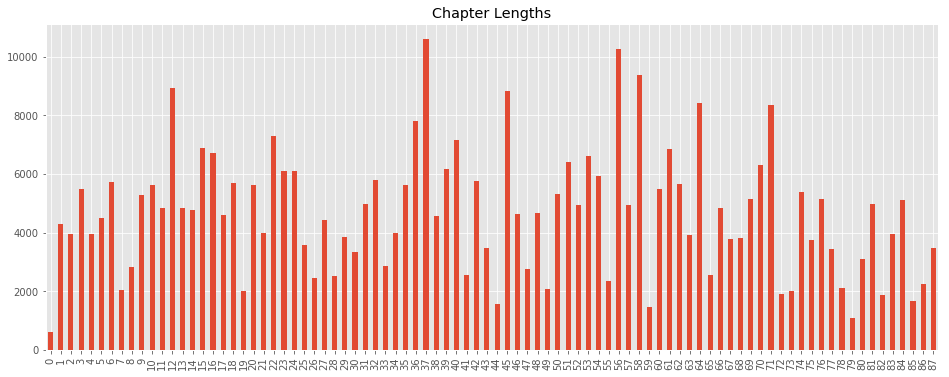

In [8]:
chapters = getChapters(mm)
chapterLengths = [len(nlp(chapter, tag=False, parse=False, entity=False)) for chapter in chapters]
chapterLengthsSeries = pd.Series(chapterLengths)
chapterLengthsSeries.plot(kind='bar', title='Chapter Lengths')

In [9]:
with open('../txt/e4.json') as f: 
    rawData = f.read()

In [10]:
df = pd.read_json(rawData)

In [19]:
df

,Locations in A,Locations in B,contributor_first_name,contributor_last_name,contributor_original_form,contributor_person_name,contributor_role,language_code,numMatches,object_type,...,publication_qualifier,publication_title,record_id,record_title,source_type,text,year,Decade,Quoted Words,Locations in A with Wordcounts
0,[],[],None,None,None,None,None,ENG,0,Review,...,London,The Athenaeum,8862020,Essays.,Historical Periodicals,Essay 8. LITERATURE By George Eliot. (Blackwoo...,1884,1880,0,[]
1,[],[],None,None,"Dickens, Charles Culliford Boz 1837-1896",None,Editor,ENG,0,Feature,...,London,All the year round,8182372,CHRONICLES OF ENGLISH COUNTIES.,Historical Periodicals,CHRONICLES OF ENGLISH COUNTIES.&apos; WARIVICK...,1884,1880,0,[]
2,"[[18417, 18603], [35109, 35254], [929122, 9293...","[[26000, 26184], [33676, 33819], [35266, 35510]]",Peter,Bayne,"Bayne, Peter",Peter Bayne,WellesleyAttribution,ENG,3,Feature,...,Edinburgh,Blackwood's Edinburgh magazine,8243995,SHAKESPEARE AND GEORGE ELIOT.,Historical Periodicals,SHAKESPEARE AND GEORGE ELIOT. Shakespeare has ...,1883,1880,124,"[([18417, 18603], 41), ([35109, 35254], 28), (..."
3,[],[],None,None,V W,None,Author,ENG,0,Review,...,London,The Athenaeum,8975729,THE ANATOMY OF FICTION,Historical Periodicals,THE ANATOMY OF FICTION L Materials and Methods...,1919,1910,0,[]
4,[],[],Henry,Reynolds,"Reynolds, Henry Robert",Henry Robert Reynolds,Editor,ENG,0,Review,...,London,The British quarterly review,8288277,Parted Lives.,Historical Periodicals,Parted Lives. By Mrs. J. K. Spender. Hurst and...,1873,1870,0,[]
5,[],[],H,LAWRENNY,"LAWRENNY, H",H LAWRENNY,Author,ENG,0,Review,...,London,"The Academy, 1869-1902, 0269-333X",6546857,Middlemarch.,Historical Periodicals,General Literature. Middlemarch. A Study of Pr...,1873,1870,0,[]
6,[],[],Ernest,Remnant,"Remnant, Ernest",Ernest Remnant,Editor,ENG,0,Review,...,London,"The English review, 1908-1937",2441325,GEORGE ELIOT: A STUDY.,Historical Periodicals,BIOGRAPHY AND MEMOIRS. GEORGE ELIOT: A STUDY. ...,1930,1930,0,[]
7,[],[],None,None,None,None,None,ENG,0,Article,...,London,The Sketch,1638085810,SMALL TALK of the WEEK,Historical Periodicals,"OUR KING, with the wonderful tact whi...",1904,1900,0,[]
8,[],[],None,None,None,None,None,ENG,0,Advertisement,...,London,"Saturday review of politics, literature, scien...",9672239,Advertisement,Historical Periodicals,"SAMPSON LOW, MARSTON &amp; CO/S NEW BOOKS FOR ...",1895,1890,0,[]
9,[],[],None,None,None,None,None,ENG,0,Review,...,London,"London quarterly review, Oct. 1862-Jan. 1932",2549048,A History of Modern England.,Historical Periodicals,A History of Modern England. By Herbert Paul. ...,1905,1900,0,[]


In [150]:
df.publication_qualifier.value_counts()

London               599
Edinburgh             24
London / New York      2
Calcutta               2
Dublin                 2
Name: publication_qualifier, dtype: int64

In [11]:
df['Decade'] = df['year'] - (df['year'] % 10)
# df['Locations in A'] = df['matches'].apply(lambda x: x[1])
# df['NumMatches'] = df['matches'].apply(lambda x: x[0])

In [12]:
sum([len(item) for item in df['Locations in A'].values])

300

In [23]:
def diachronicAnalysis(df, decades=(1950, 2020), bins=chapterLocations): 
    decades = np.arange(decades[0], decades[1], 10)
    # Make a dictionary of decades. 
    # Values are a list of locations.  
    decadeDict = {}
    for i, row in df.iterrows():
        decade = row['Decade']
        locationsAndWordcounts = row['Locations in A with Wordcounts']
        if decade not in decadeDict: 
            decadeDict[decade] = locationsAndWordcounts
        else: 
            decadeDict[decade] += locationsAndWordcounts
    # Grab the beginnings of quotes. 
    decadeStartsWeights = {decade: [(item[0][0], item[1]) 
                                    for item in loc] 
                    for decade, loc in decadeDict.items()}
    decadesBinned = {decade: 
                 np.histogram([loc[0] for loc in locations], 
                              bins=bins,
                              weights=[loc[1] for loc in locations],
                              range=(0, textALength))[0]
                 for decade, locations in decadeStartsWeights.items() 
                     if decade in decades}
    decadesDF = pd.DataFrame(decadesBinned).T
    #Normalize
    decadesDF = decadesDF.div(decadesDF.max(axis=1), axis=0)
    return decadesDF

def countWords(locRange): 
    """ Counts words in middlemarch, given character ranges. """
    doc = nlp(mm[locRange[0]:locRange[1]], tag=False, parse=False, entity=False)
    return len(doc)

def totalWords(locRangeSet): 
    """ Counts total words in a list of location ranges. """
    return sum([countWords(locRange) for locRange in locRangeSet])    
    
def countsPerSet(locRangeSet): 
    """ Returns an augmented location range set that includes word counts. """
    return [(locRange, countWords(locRange))
             for locRange in locRangeSet]
    
def synchronicAnalysis(df, bins=chapterLocations): 
    locs = df['Locations in A'].values
    locCounts = [(loc, countWords(loc)) for locSet in locs
              for loc in locSet]
    starts = [loc[0][0] for loc in locCounts]
    counts = [loc[1] for loc in locCounts]
    binned = np.histogram(starts, bins=bins, 
                          weights=counts, range=(0, textALength))
    binnedDF = pd.Series(binned[0])
    return binnedDF

def plotDiachronicAnalysis(df): 
    ylabels = [str(int(decade)) for decade in df.index] #+ ['2020']
    plt.pcolor(df, cmap='gnuplot')
    plt.yticks(np.arange(len(df.index)+1), ylabels)
    plt.gca().invert_yaxis()
    plt.ylabel('Decade')
    plt.xlabel('Chapter')
#     plt.title("Frequency of Quotations from George Eliot's Middlemarch in Criticism, By Decade")
    plt.gca().set_xlim((0, len(df.T)))
    plt.colorbar(ticks=[])
    plt.show()
    
def plotSynchronicAnalysis(s): 
    ax = s.plot(kind='bar')
    ax.set_xlabel('Chapter')
    ax.set_ylabel('Number of Words Quoted')

In [15]:
df['Quoted Words'] = df['Locations in A'].apply(totalWords)

In [16]:
df['Locations in A with Wordcounts'] = df['Locations in A'].apply(countsPerSet)

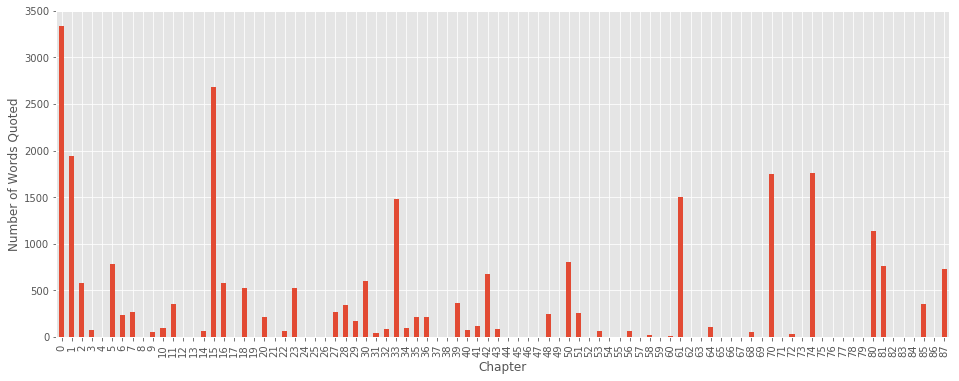

In [17]:
plotSynchronicAnalysis(synchronicAnalysis(df))

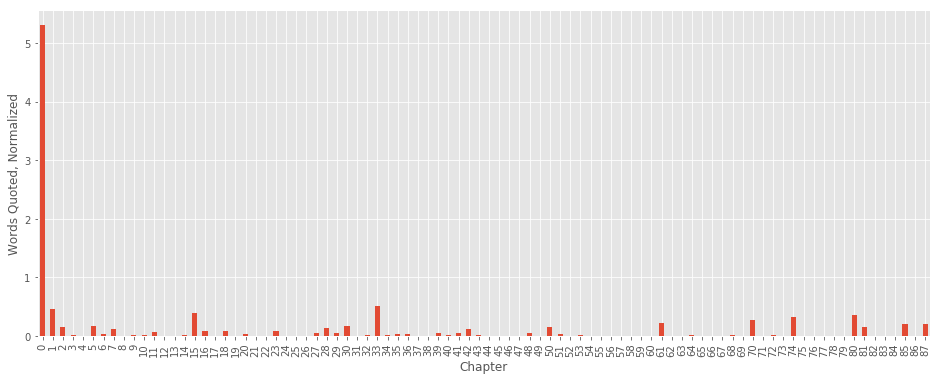

In [18]:
# Adjusted for the number of words in each chapter
ax = (synchronicAnalysis(df) / chapterLengthsSeries).plot(kind='bar')
ax.set_xlabel('Chapter')
ax.set_ylabel('Words Quoted, Normalized')

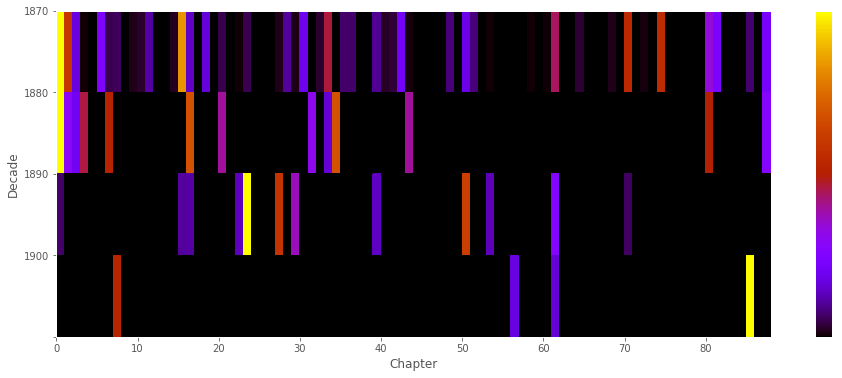

In [25]:
plotDiachronicAnalysis(diachronicAnalysis(df, decades=(1870, 1910), bins=chapterLocations))

# By Journal

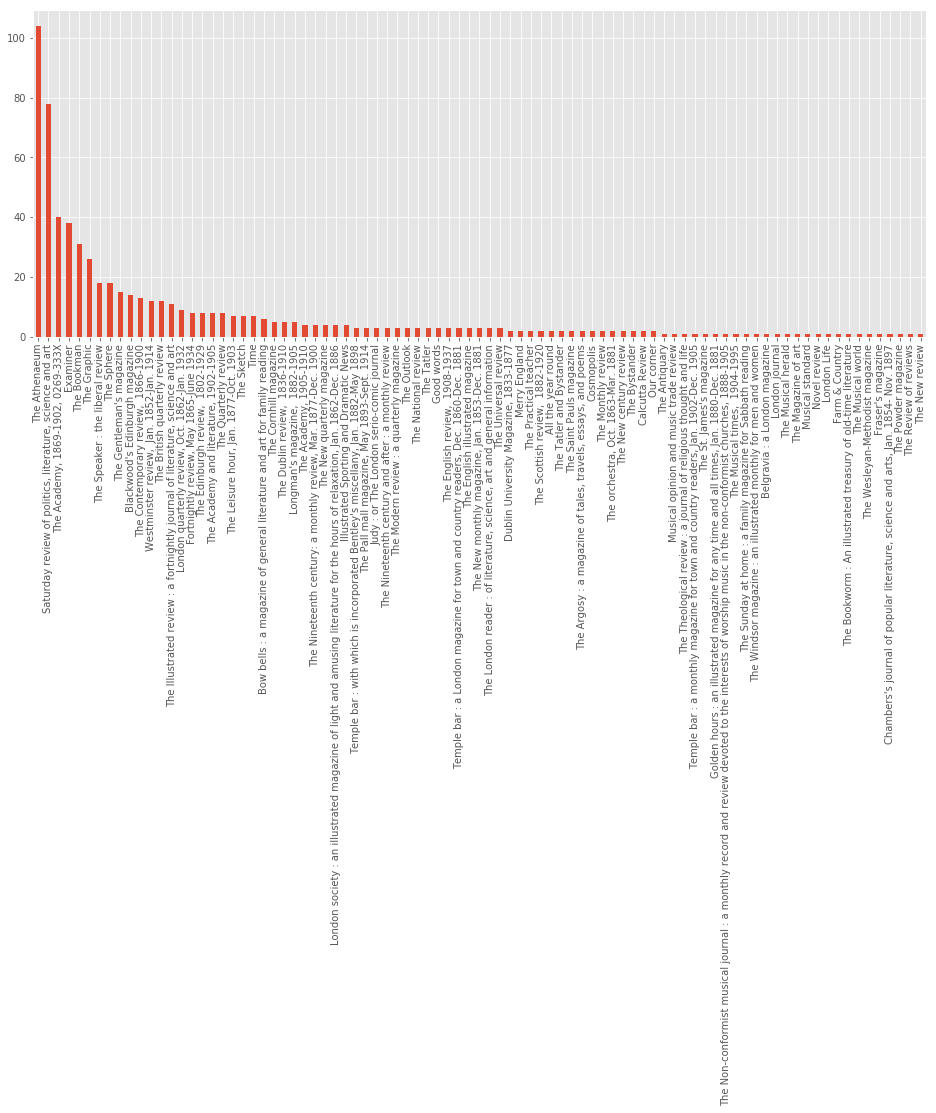

In [75]:
# Look at the top journals. 
journals = df['publication_title'].value_counts()
journals.plot(kind='bar')

Compare journals. 

In [76]:
journalDict = {title: synchronicAnalysis(df.loc[df['publication_title'] == title]) for title in journals.index}

In [104]:
byJournal = pd.DataFrame(journalDict).T
# byJournal

In [105]:
byJournal

,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
All the year round,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Belgravia : a London magazine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Blackwood's Edinburgh magazine,0.0,756.0,198.0,0.0,0.0,112.0,0.0,198.0,0.0,55.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,227.0,0.0,0.0
Bow bells : a magazine of general literature and art for family reading,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Calcutta Review,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Chambers's journal of popular literature, science and arts, Jan. 1854- Nov. 1897",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cosmopolis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Dublin University Magazine, 1833-1877",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Examiner,501.0,204.0,0.0,0.0,0.0,676.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Farm & Country,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
cutoff = 500 # Number of words
topJournals = byJournal.loc[byJournal.sum(axis=1) >= cutoff]
otherJournals = byJournal.loc[byJournal.sum(axis=1) <= cutoff]
topJournals.loc['Other'] = otherJournals.sum()

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [134]:
topJournals.sum(axis=1)

Blackwood's Edinburgh magazine                  2713.0
Examiner                                        6089.0
London quarterly review, Oct. 1862-Jan. 1932    3970.0
The Athenaeum                                   2366.0
The British quarterly review                    2228.0
The Cornhill magazine                            519.0
The Edinburgh review,  1802-1929                3440.0
The Graphic                                      624.0
The orchestra, Oct. 1863-Mar. 1881              2141.0
Other                                           2821.0
dtype: float64

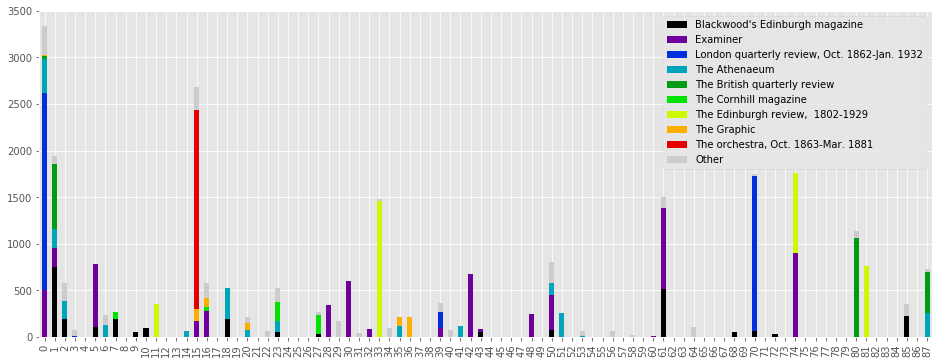

In [146]:
ax = topJournals.T.plot(kind='bar', stacked=True, colormap='nipy_spectral')
ax.set_ylabel = "Chapter" 
ax.set_xlabel = "Number of Words Quoted"